# CLUSTERING 



# Importación de Librerías 
Este código importa las bibliotecas necesarias para realizar análisis de datos, visualización, preprocesamiento y clustering en Python.

## Importación de bibliotecas

- **`pandas`**: Biblioteca para la manipulación y análisis de datos estructurados en forma de tablas (DataFrames).  
- **`numpy`**: Biblioteca para cálculos numéricos y manipulación de arreglos multidimensionales.  
- **`matplotlib.pyplot`**: Herramienta para crear visualizaciones gráficas (gráficos de líneas, barras, dispersión, etc.).  
- **`seaborn`**: Biblioteca basada en `matplotlib` que facilita la creación de visualizaciones estadísticas avanzadas.  
- **`warnings.filterwarnings('ignore')`**: Suprime las advertencias para evitar distracciones durante la ejecución del código.  

---

## Preprocesamiento de datos

- **`MinMaxScaler`**: Escala las características en un rango específico (por defecto, entre 0 y 1), útil para algoritmos sensibles a la escala de los datos.  
- **`Pipeline`**: Permite encadenar múltiples pasos de preprocesamiento y modelado en una secuencia estructurada.  

---

## Algoritmos de clustering

Se importan varios algoritmos de clustering para agrupar datos según patrones similares:

- **`KMeans`**: Algoritmo basado en centroides que particiona los datos en K grupos.  
- **`DBSCAN`**: Algoritmo basado en densidad, útil para detectar clusters de formas arbitrarias y manejar ruido.  
- **`AgglomerativeClustering`**: Algoritmo jerárquico que agrupa los datos mediante un enfoque de fusión ascendente.  
- **`MeanShift`**: Algoritmo basado en estimación de densidad que encuentra clusters sin necesidad de especificar el número de grupos.  
- **`GaussianMixture`**: Modelo probabilístico basado en la combinación de múltiples distribuciones gaussianas para identificar clusters.  

---

## Evaluación y optimización de modelos

- **`GridSearchCV`**: Herramienta para realizar la búsqueda de hiperparámetros óptimos mediante validación cruzada.  
- **`silhouette_score`**: Métrica de evaluación que mide la calidad del agrupamiento en términos de cohesión y separación de clusters.  
- **`make_scorer`**: Convierte una métrica en un formato compatible con `GridSearchCV` para optimización de modelos.  


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

# Preproceso del Dataset
El código realiza la carga y preprocesamiento de datos de calidad del aire desde un archivo CSV.

## Carga de datos  
Se carga el archivo de datos utilizando la librería `pandas`, especificando el delimitador adecuado para su correcta interpretación.

## Conversión de fechas y creación de variables derivadas  
Se convierten las columnas de fecha a un formato de fecha y hora adecuado. Luego, se extraen componentes como el día, mes y año, creando nuevas columnas con estos valores.  

## Conversión de la columna de hora  
Se transforma la columna de tiempo en un formato de hora reconocible para facilitar su manipulación.

## Mapeo de días de la semana  
Se genera una nueva columna que almacena el nombre del día de la semana correspondiente a cada fecha y se convierte a valores numéricos utilizando un diccionario de mapeo.
Esta columna se crea para luego poder entrenar los modelos. 

## Categorización por partes del día  
Se define una función que categoriza las horas en tres períodos del día:  
- **Mañana (Día):** 6 AM - 12 PM  
- **Tarde:** 12 PM - 6 PM  
- **Noche:** 6 PM - 6 AM  
Esta función se aplica a la columna de tiempo.
Esta columna se crea para luego poder entrenar los modelos. 

## Reemplazo de caracteres y conversión de tipos de datos  
Se reemplazan las comas por puntos en ciertas columnas para permitir la conversión a formato numérico de punto flotante.

## Conversión de valores numéricos a enteros  
Se verifica si las columnas numéricas contienen solo valores enteros y, en ese caso, se convierten al tipo de dato entero compatible con valores nulos.

## Eliminación de columnas innecesarias  
Se eliminan columnas irrelevantes o vacías que no aportan información útil para el análisis. 

Borramos `Unnamed: 15`, `Unnamed: 16`, `Time`. 

Las 2 primeras columnas se borrar porque estan vacias y la de `Time` la borramos porque la hora ya la tenemos con la columna `PeriodoDia`.

## Limpieza de filas con valores faltantes  
Se eliminan las filas donde todos los valores son nulos para mantener la calidad del dataset.

## Visualización de información  
Finalmente, se muestra la estructura del DataFrame, incluyendo los tipos de datos de cada columna y los primeros registros del conjunto de datos para su inspección.

In [3]:
# Cargar los datos
df = pd.read_csv('data/AirQuality.csv', delimiter=';')

# Convertir las fechas y horas
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce')
# Crear las variables derivadas de 'Date'
df['Dia'] = df['Date'].dt.day
df['Mes'] = df['Date'].dt.month
df['Anio'] = df['Date'].dt.year

df['Time'] = pd.to_datetime(df['Time'], format='%H.%M.%S', errors='coerce').dt.time

# Mapear días de la semana a números
df['DiaSemana'] = df['Date'].dt.day_name()
dias_semana_map = {
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2,
    'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6
}
df['DiaSemana'] = df['DiaSemana'].map(dias_semana_map)

# Categorizar por partes del día
def time_to_period(hour):
    if 6 <= hour < 12:
        return 0 #Día
    elif 12 <= hour < 18:
        return 1 #Tarde
    else:
        return 2 #Noche

df['PeriodoDia'] = df['Time'].apply(lambda t: time_to_period(t.hour) if pd.notnull(t) else None)

# Reemplazar comas por puntos y convertir columnas a float
columns_to_convert = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']
for col in columns_to_convert:
    df[col] = df[col].str.replace(',', '.', regex=False).astype(float)

# Convertir todas las columnas numéricas a enteros si no tienen decimales
for col in df.select_dtypes(include=['float', 'int']).columns:
    if df[col].dropna().mod(1).eq(0).all():  # Verifica si todos los valores son enteros
        df[col] = df[col].astype('Int64')  # Convierte a entero compatible con NaN

# Configuración para que no muestre decimales en pandas
pd.set_option('display.float_format', '{:.0f}'.format)


# Eliminar columnas innecesarias
df = df.drop(columns=['Unnamed: 15', 'Unnamed: 16', 'Time'], errors='ignore')
# Eliminar filas donde todos los valores, incluyendo el índice, sean NaN
df = df.dropna()

# Mostrar información y primeros registros
print("Tipos de datos:")
print(df.dtypes)
print("\nPrimeros registros:")
print(df.head())



Tipos de datos:
Date             datetime64[ns]
CO(GT)                  float64
PT08.S1(CO)               Int64
NMHC(GT)                  Int64
C6H6(GT)                float64
PT08.S2(NMHC)             Int64
NOx(GT)                   Int64
PT08.S3(NOx)              Int64
NO2(GT)                   Int64
PT08.S4(NO2)              Int64
PT08.S5(O3)               Int64
T                       float64
RH                      float64
AH                      float64
Dia                       Int64
Mes                       Int64
Anio                      Int64
DiaSemana                 Int64
PeriodoDia                Int64
dtype: object

Primeros registros:
        Date  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
0 2004-03-10       3         1360       150        12           1046      166   
1 2004-03-10       2         1292       112         9            955      103   
2 2004-03-10       2         1402        88         9            939      131   
3 2004-03-10     

# IMPUTAR VALORES -200 A NAN Y PONER A LOS DEMAS MEDIA O MEDIANA

In [4]:


# Columnas a imputar (excepto 'NMHC(GT)')
imputar_nan = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)','PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

# Eliminar la columna 'NMHC(GT)'
df = df.drop(columns=['NMHC(GT)'], errors='ignore')

# Convertir columnas a tipo float para evitar problemas de tipo de dato
df[imputar_nan] = df[imputar_nan].astype(float)

# Reemplazar valores -200 con NaN en las columnas seleccionadas
df[imputar_nan] = df[imputar_nan].replace(-200, np.nan)

# Imputación con la media (redondeando a 2 decimales)
df_mean_imputed = df.copy()
df_mean_imputed[imputar_nan] = df_mean_imputed[imputar_nan].fillna(df_mean_imputed[imputar_nan].mean()).round(2)


# Imputación con la mediana (redondeando a 2 decimales)
df_median_imputed = df.copy()
df_median_imputed[imputar_nan] = df_median_imputed[imputar_nan].fillna(df_median_imputed[imputar_nan].median()).round(2)


# Comparar los resultados
print("Con imputación de la media:")
print(df_mean_imputed[imputar_nan].head())

print("\nCon imputación de la mediana:")
print(df_median_imputed[imputar_nan].head())

# Verificar tipos de datos después de la conversión
print(df.dtypes)


Con imputación de la media:
   CO(GT)  C6H6(GT)  NOx(GT)  NO2(GT)  PT08.S1(CO)  PT08.S2(NMHC)  \
0       3        12      166      113         1360           1046   
1       2         9      103       92         1292            955   
2       2         9      131      114         1402            939   
3       2         9      172      122         1376            948   
4       2         6      131      116         1272            836   

   PT08.S3(NOx)  PT08.S4(NO2)  PT08.S5(O3)  T  RH  AH  
0          1056          1692         1268 14  49   1  
1          1174          1559          972 13  48   1  
2          1140          1555         1074 12  54   1  
3          1092          1584         1203 11  60   1  
4          1205          1490         1110 11  60   1  

Con imputación de la mediana:
   CO(GT)  C6H6(GT)  NOx(GT)  NO2(GT)  PT08.S1(CO)  PT08.S2(NMHC)  \
0       3        12      166      113         1360           1046   
1       2         9      103       92         1292  

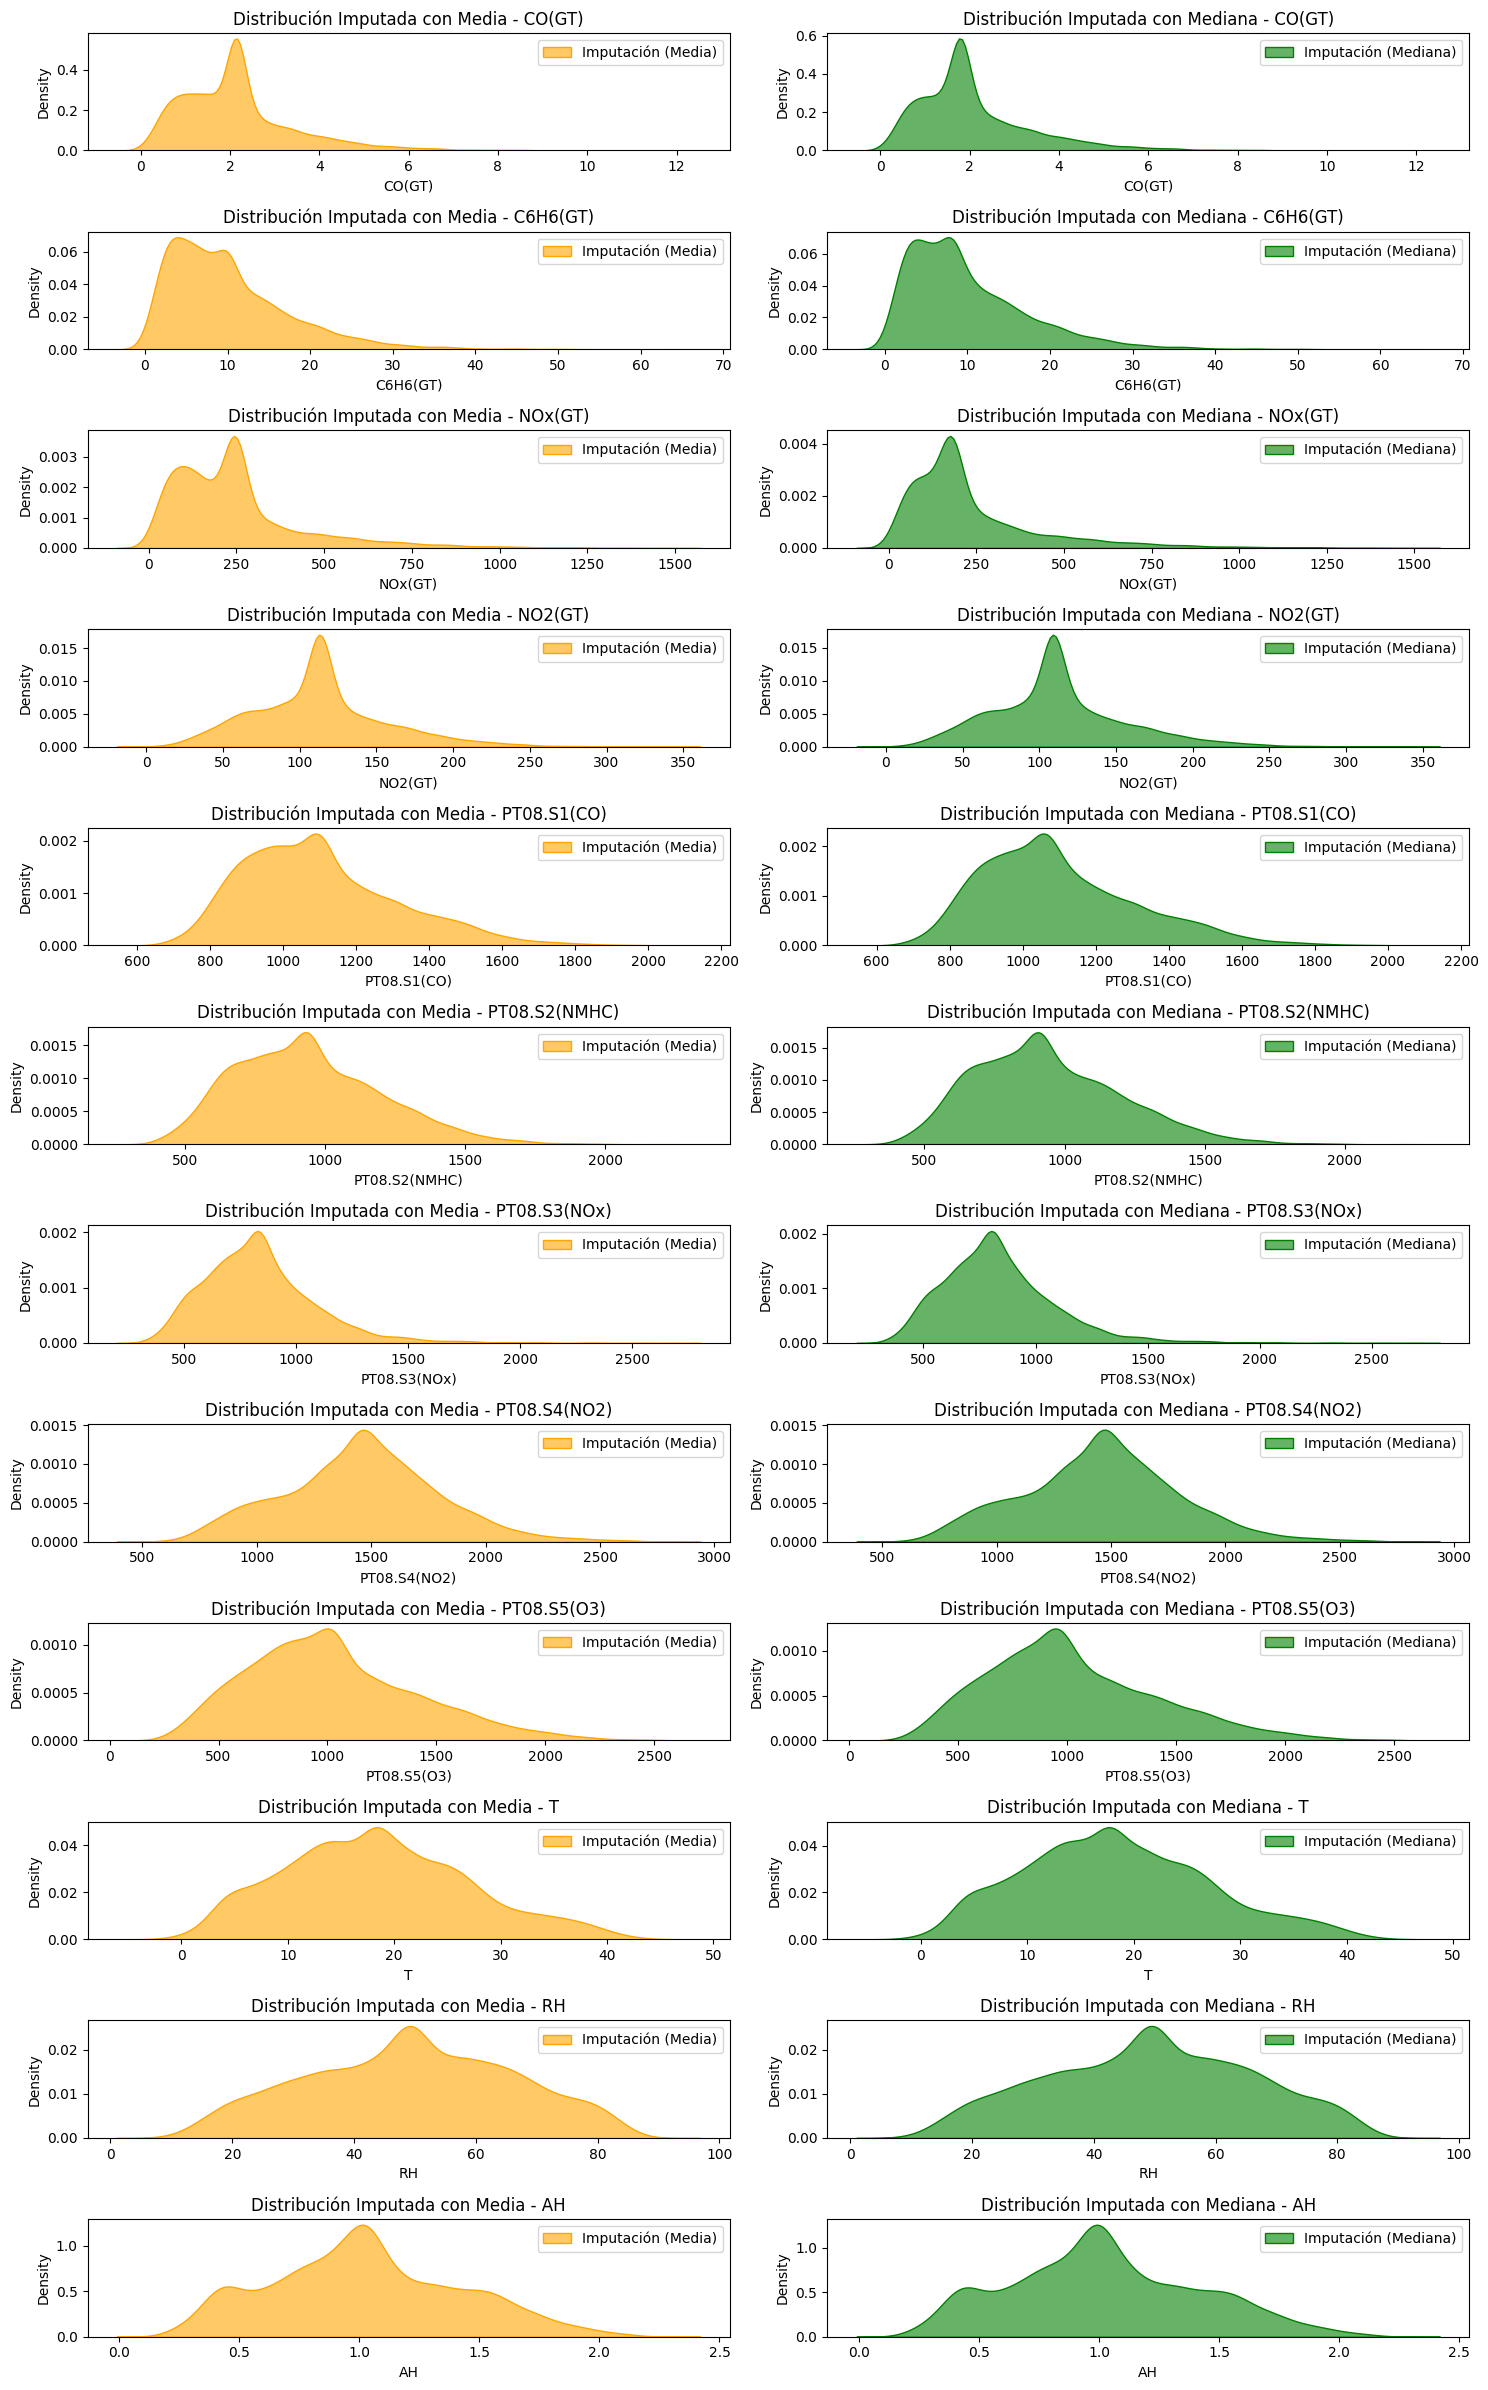

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un gráfico para visualizar la distribución de las columnas imputadas con la media y la mediana
fig, ax = plt.subplots(len(imputar_nan), 2, figsize=(15, 2 * len(imputar_nan)))

for i, col in enumerate(imputar_nan):
    # Distribución de los datos imputados con media
    sns.kdeplot(df_mean_imputed[col], ax=ax[i, 0], color='orange', fill=True, label='Imputación (Media)', alpha=0.6)
    ax[i, 0].set_title(f'Distribución Imputada con Media - {col}')
    ax[i, 0].legend()

    # Distribución de los datos imputados con mediana
    sns.kdeplot(df_median_imputed[col], ax=ax[i, 1], color='green', fill=True, label='Imputación (Mediana)', alpha=0.6)
    ax[i, 1].set_title(f'Distribución Imputada con Mediana - {col}')
    ax[i, 1].legend()

plt.tight_layout()
plt.show()


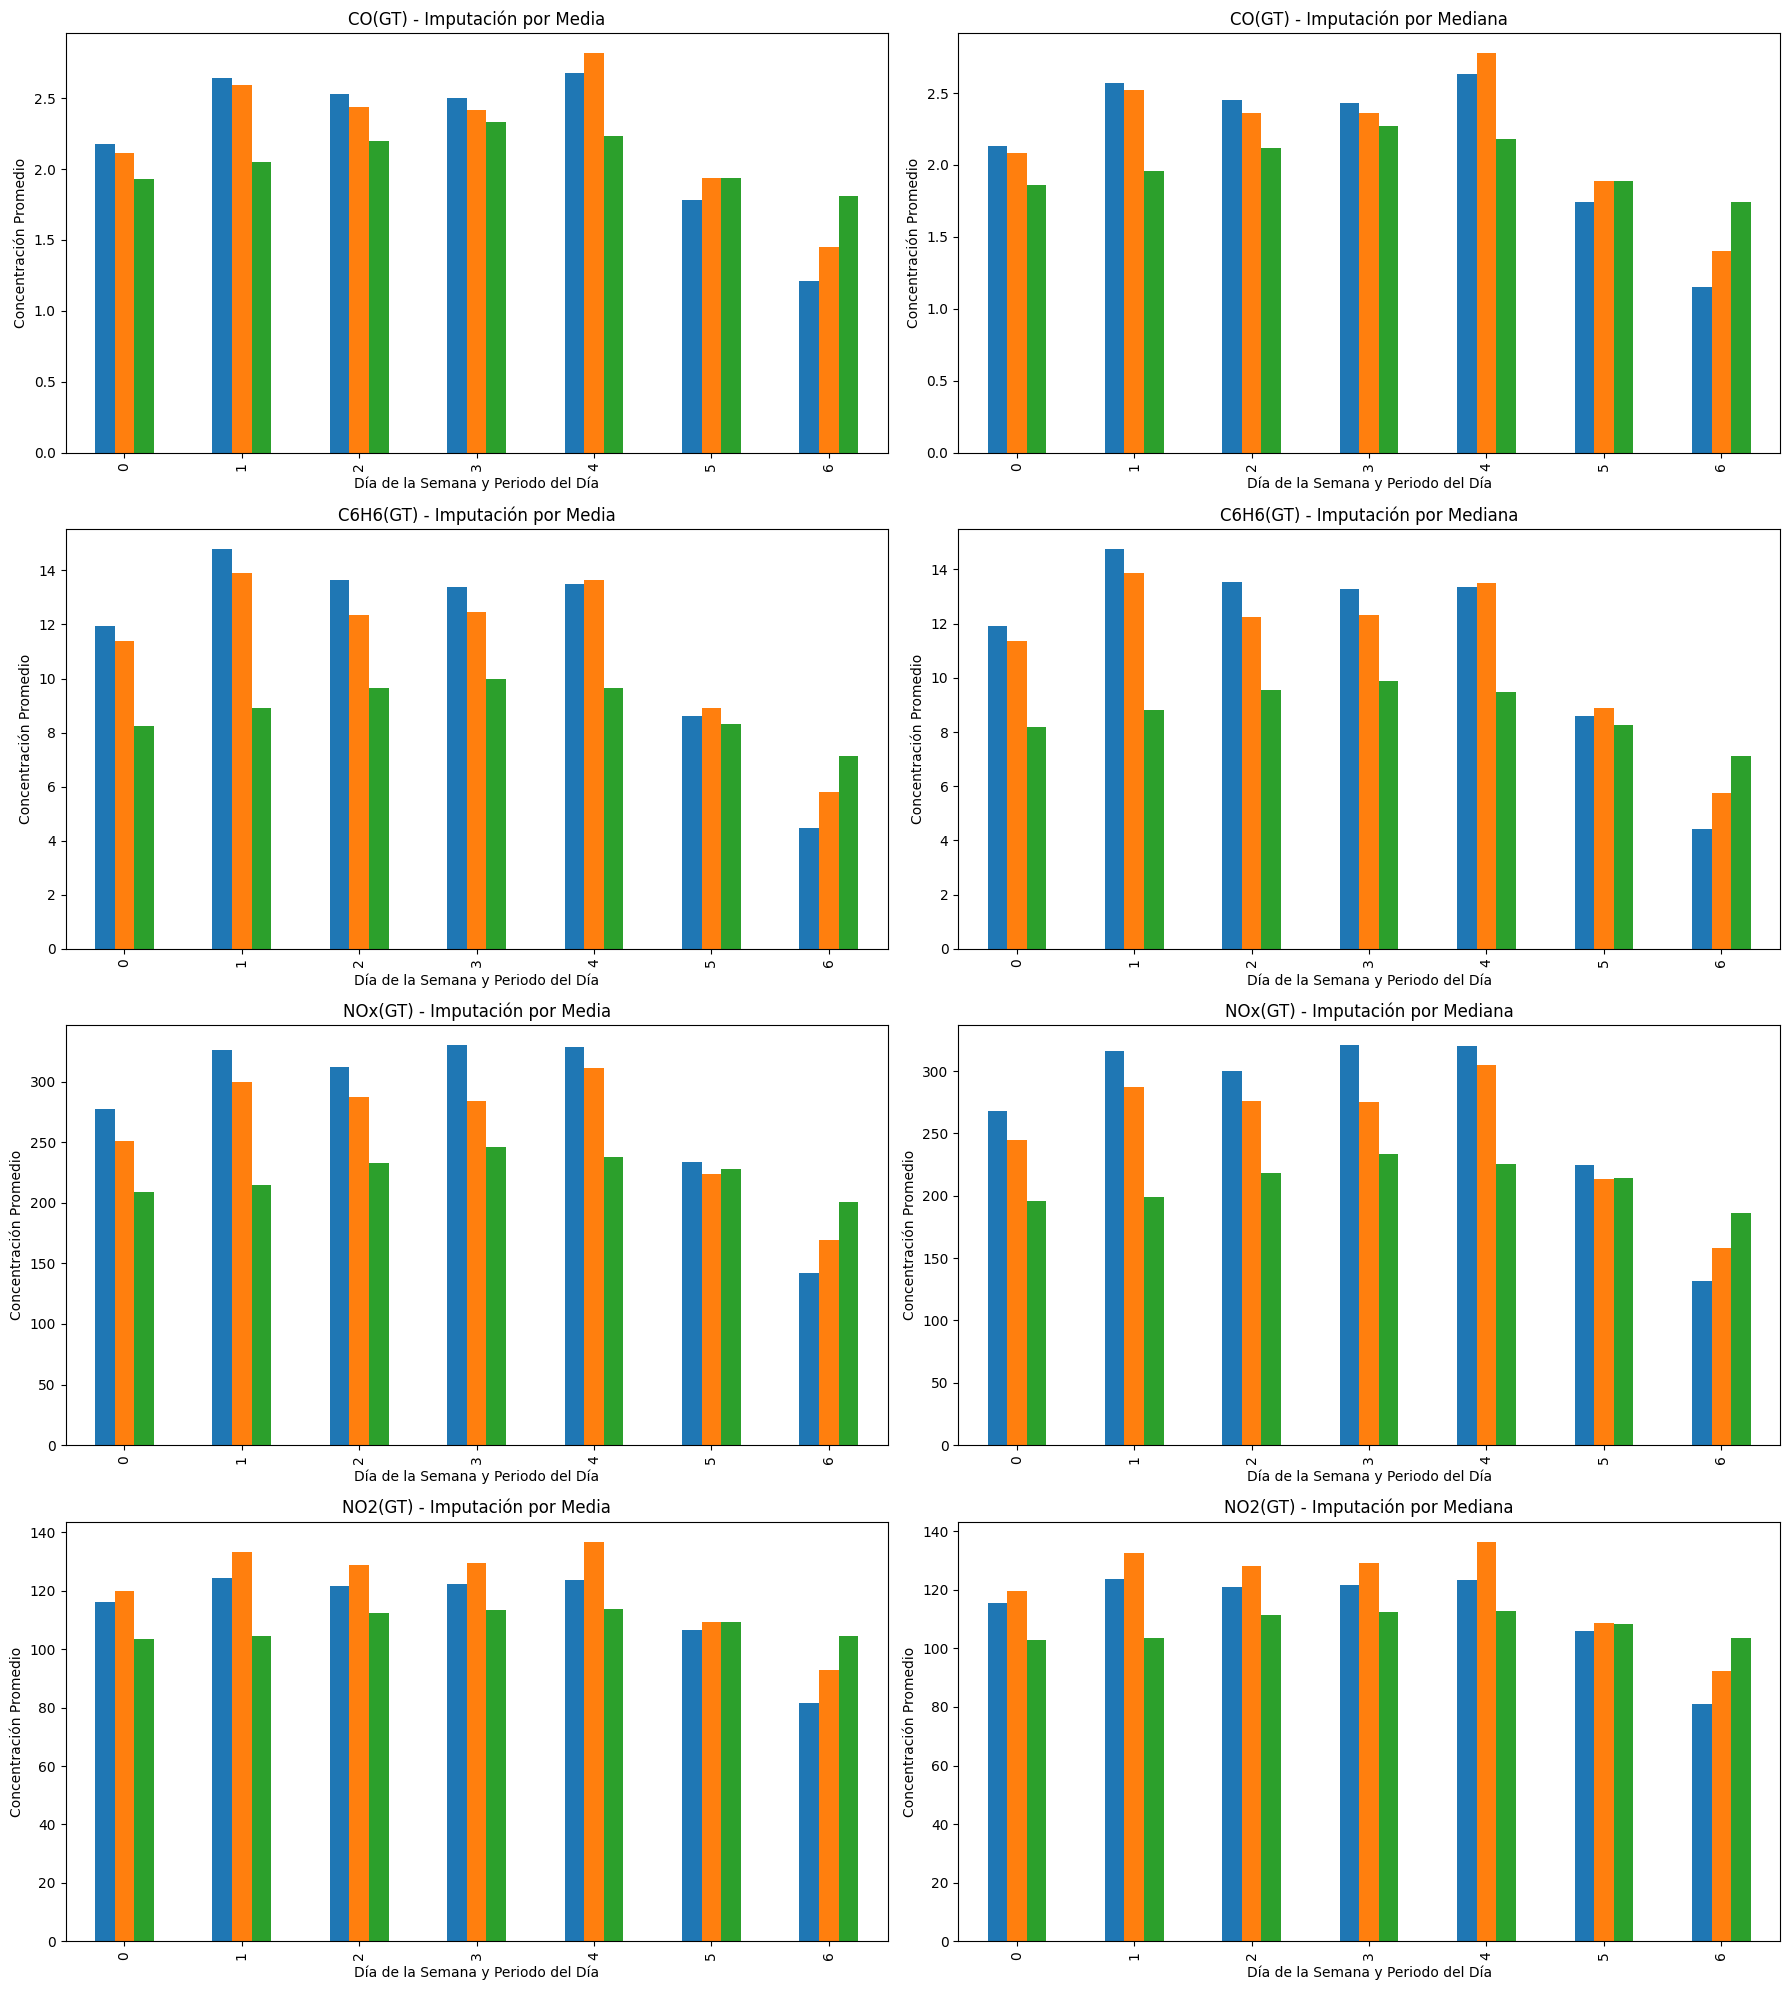

In [6]:


# Seleccionar las columnas de interés
gases_media_semana = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 'PeriodoDia', 'DiaSemana']
gases = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']

# Agrupar por día de la semana y periodo del día, y calcular la media de cada gas para cada método
df_grouped_mean = df_mean_imputed[gases_media_semana].groupby(['DiaSemana', 'PeriodoDia']).mean().reset_index().round(2)
df_grouped_median = df_median_imputed[gases_media_semana].groupby(['DiaSemana', 'PeriodoDia']).mean().reset_index().round(2)

# Crear una figura con subgráficos de 2 columnas (una para cada método)
fig, axes = plt.subplots(len(gases), 2, figsize=(18, 20))

# Generar los gráficos comparativos
for i, gas in enumerate(gases):
    # Datos imputados con la media
    gas_data_mean = df_grouped_mean[['DiaSemana', 'PeriodoDia', gas]].set_index(['DiaSemana', 'PeriodoDia']).unstack()
    gas_data_mean.plot(kind='bar', ax=axes[i, 0], legend=False)
    axes[i, 0].set_title(f'{gas} - Imputación por Media')
    axes[i, 0].set_xlabel('Día de la Semana y Periodo del Día')
    axes[i, 0].set_ylabel('Concentración Promedio')

    # Datos imputados con la mediana
    gas_data_median = df_grouped_median[['DiaSemana', 'PeriodoDia', gas]].set_index(['DiaSemana', 'PeriodoDia']).unstack()
    gas_data_median.plot(kind='bar', ax=axes[i, 1], legend=False)
    axes[i, 1].set_title(f'{gas} - Imputación por Mediana')
    axes[i, 1].set_xlabel('Día de la Semana y Periodo del Día')
    axes[i, 1].set_ylabel('Concentración Promedio')

# Ajustar la distribución de los gráficos
plt.tight_layout()
plt.show()


# outliders 

In [7]:

# Columnas a analizar
columns_to_check = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 'PT08.S1(CO)', 
                    'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

# Detectar outliers usando IQR
for col in columns_to_check:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Definir límites para valores atípicos
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f'{col} tiene {outliers.shape[0]} valores atípicos.')


CO(GT) tiene 215 valores atípicos.
C6H6(GT) tiene 228 valores atípicos.
NOx(GT) tiene 435 valores atípicos.
NO2(GT) tiene 107 valores atípicos.
PT08.S1(CO) tiene 118 valores atípicos.
PT08.S2(NMHC) tiene 65 valores atípicos.
PT08.S3(NOx) tiene 241 valores atípicos.
PT08.S4(NO2) tiene 97 valores atípicos.
PT08.S5(O3) tiene 93 valores atípicos.
T tiene 3 valores atípicos.
RH tiene 0 valores atípicos.
AH tiene 2 valores atípicos.


# COMO HAY OUTLIDERS VAMOS A USAR LA MEDIANA 
Si se requiere una mayor estabilidad y resistencia al ruido, es mejor la mediana.

# DATOS NORMALOIZADOS Y SACAR INDICE DE CONTAMINACIÓN 

In [8]:


# Seleccionar las columnas relevantes de gases contaminantes
gases_contaminantes = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
otras_columnas = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

# Combinar todas las columnas que se van a normalizar
columnas_a_normalizar = gases_contaminantes + otras_columnas

# Convertir las columnas a tipo numérico, manejando errores
df_median_imputed[columnas_a_normalizar] = df_median_imputed[columnas_a_normalizar].apply(pd.to_numeric, errors='coerce')


# Crear un objeto MinMaxScaler
scaler = MinMaxScaler()
df_median_imputed_norm = df_median_imputed.copy()

# Normalizar las columnas seleccionadas
df_median_imputed_norm[columnas_a_normalizar] = scaler.fit_transform(df_median_imputed_norm[columnas_a_normalizar])

# Normalizar las columnas de gases contaminantes
df_median_imputed_norm[gases_contaminantes] = scaler.fit_transform(df_median_imputed_norm[gases_contaminantes])

# Calcular la media de los gases contaminantes para cada fila
df_median_imputed_norm['indeceContaminacion'] = df_median_imputed_norm[gases_contaminantes].mean(axis=1)

# Normalizar el índice usando MinMaxScaler
df_median_imputed_norm['indeceContaminacion'] = scaler.fit_transform(df_median_imputed_norm[['indeceContaminacion']])

# Redondear los valores a 2 decimales
df_median_imputed_norm[columnas_a_normalizar] = df_median_imputed_norm[columnas_a_normalizar].round(2)
df_median_imputed_norm['indeceContaminacion'] = df_median_imputed_norm['indeceContaminacion'].round(2)


# Mostrar el resultado
print(df_median_imputed_norm[['indeceContaminacion']].head())

   indeceContaminacion
0                    0
1                    0
2                    0
3                    0
4                    0


# hacer indice d la calidad del aire, gas x gas 

# CO x dias de la semana

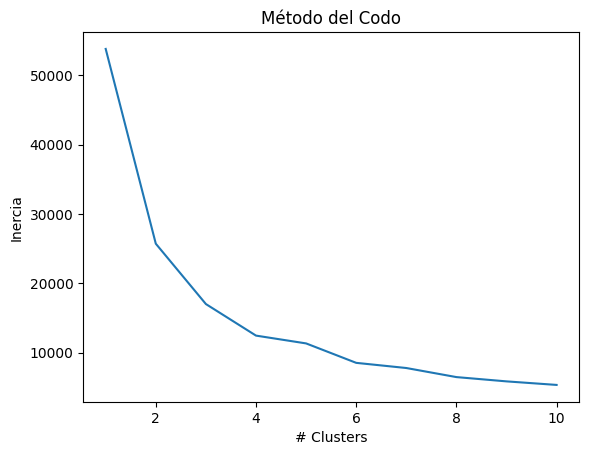

Número óptimo de clusters: 2


In [9]:
variable_X_CO = df_median_imputed[['CO(GT)','DiaSemana']]

# Función que calcula y dibuja el gráfico para utilizar el método del codo.
def elbow_method_kmeans(data, range_a, range_b):
    inercia = []
    for i in range(range_a, range_b):
        kmeans = KMeans(n_clusters=i, random_state=0)
        kmeans.fit(data)
        inercia.append(kmeans.inertia_)
    
    # Gráfico del codo
    plt.plot(range(range_a, range_b), inercia)
    plt.xlabel('# Clusters')
    plt.ylabel('Inercia')
    plt.title('Método del Codo')
    plt.show()

    # Cálculo del cambio en la inercia
    diffs = np.diff(inercia)
    optimal_k = np.argmin(diffs) + range_a + 1  # +1 porque np.diff reduce la longitud de la lista
    return optimal_k

# Determinar el número óptimo de clusters
optimal_clusters = elbow_method_kmeans(variable_X_CO, 1, 11)
print(f'Número óptimo de clusters: {optimal_clusters}')


Evaluando KMeans...
Fitting 1 folds for each of 180 candidates, totalling 180 fits

Evaluando MeanShift...
Fitting 1 folds for each of 64 candidates, totalling 64 fits

Evaluando GMM...
Fitting 1 folds for each of 2592 candidates, totalling 2592 fits

Evaluando DBSCAN...
Fitting 1 folds for each of 108 candidates, totalling 108 fits

Evaluando AgglomerativeClustering...
Fitting 1 folds for each of 16 candidates, totalling 16 fits

Modelo: KMeans
Silhouette Score: 0.6384840808730027
Mejores hiperparámetros seleccionados:
  algorithm: lloyd
  copy_x: True
  init: k-means++
  max_iter: 50
  n_clusters: 2
  n_init: 10
  random_state: 42
  tol: 0.0001
  verbose: 0


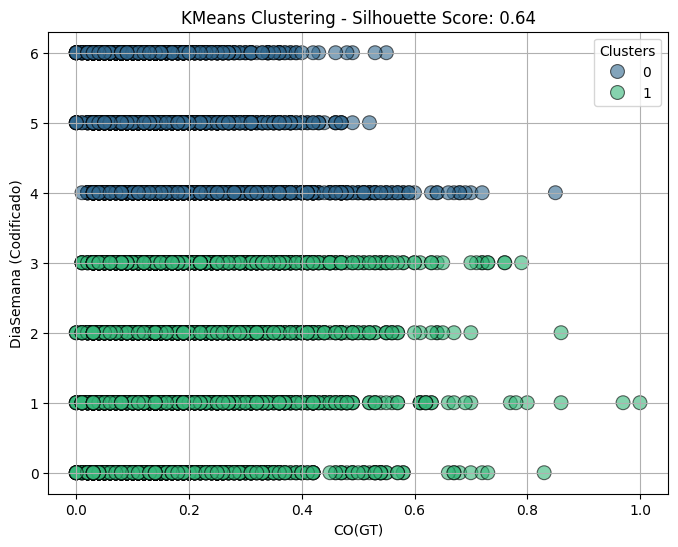


Modelo: MeanShift
Silhouette Score: 0.890203659692883
Mejores hiperparámetros seleccionados:
  bandwidth: 0.5
  bin_seeding: True
  cluster_all: True
  max_iter: 300
  min_bin_freq: 1
  n_jobs: None
  seeds: None


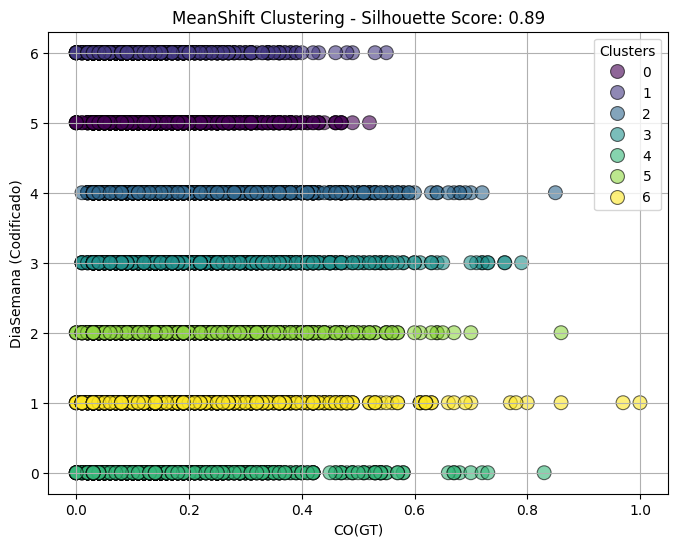


Modelo: GMM
Silhouette Score: 0.4963435682441069
Mejores hiperparámetros seleccionados:
  covariance_type: full
  init_params: kmeans
  max_iter: 100
  means_init: None
  n_components: 2
  n_init: 1
  precisions_init: None
  random_state: 42
  reg_covar: 1e-06
  tol: 0.001
  verbose: 0
  verbose_interval: 10
  warm_start: False
  weights_init: None


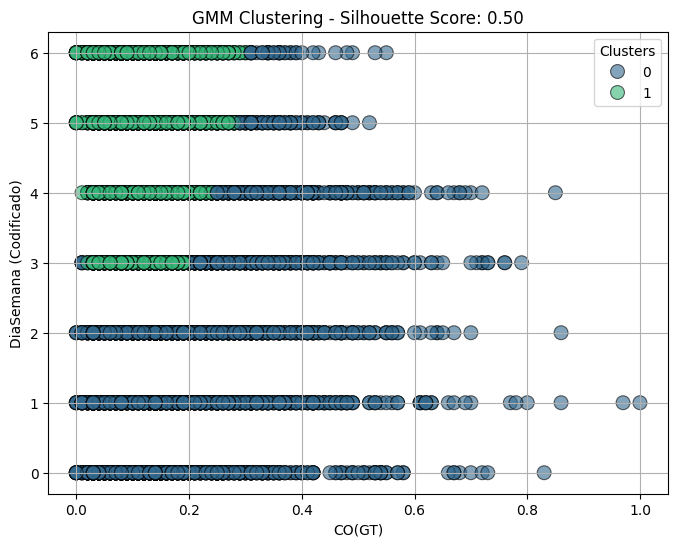


Modelo: DBSCAN
Silhouette Score: 0.890203659692883
Mejores hiperparámetros seleccionados:
  algorithm: auto
  eps: 0.3
  leaf_size: 30
  metric: euclidean
  metric_params: None
  min_samples: 5
  n_jobs: -1
  p: 2


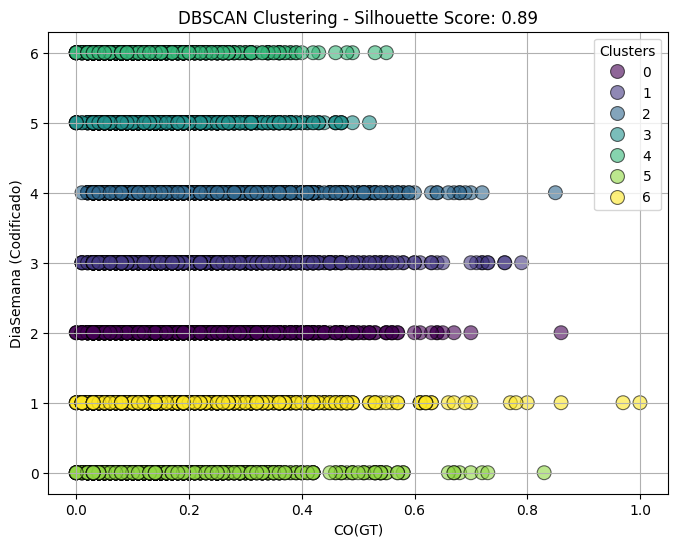


Modelo: AgglomerativeClustering
Silhouette Score: 0.6384684041975253
Mejores hiperparámetros seleccionados:
  compute_distances: False
  compute_full_tree: True
  connectivity: None
  distance_threshold: None
  linkage: ward
  memory: None
  metric: euclidean
  n_clusters: 2


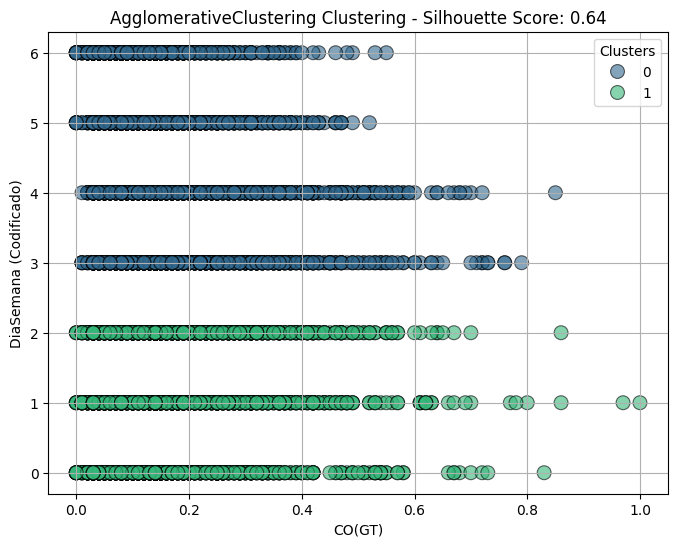

In [10]:
# Paso 2: Definir modelos y espacios de parámetros
clustering_models = {
    'KMeans': KMeans(),
    'MeanShift': MeanShift(),
    'GMM': GaussianMixture(),
    'DBSCAN': DBSCAN(),
    'AgglomerativeClustering': AgglomerativeClustering()
}

param_grids = {
    'KMeans': {
        'model__n_clusters': [optimal_clusters],                  # Número de clusters.
        'model__init': ['k-means++', 'random'],          # Método para inicializar los centros.
        'model__max_iter': [50, 200, 300, 500, 1000],                        # Máximo número de iteraciones.
        'model__tol': [1e-4, 1e-5, 1e-8],                            # Tolerancia para la convergencia.
        'model__algorithm': ['lloyd', 'elkan'],   # Algoritmo para el cálculo (auto es el predeterminado).
        'model__n_init': [10, 20, 30],                           # Número de inicializaciones del algoritmo.
        'model__random_state': [42]   
    },
    'MeanShift': {
        'model__bandwidth': [0.5, 1.0, 2.0, 3.0],              # Ancho de banda para el algoritmo.
        'model__bin_seeding': [True, False],             # Usar semillas de bin para acelerar el cálculo.
        'model__min_bin_freq': [1,  5],                      # Frecuencia mínima de puntos para considerar un bin.
        'model__cluster_all': [True, False],             # Si se agrupan todos los puntos o no.
        'model__max_iter': [300, 500 ]
    },
    'GMM': { 
        'model__n_components': [2, 3, 4, 5],                   # Número de componentes gaussianos (clusters).
        'model__covariance_type': ['full', 'tied', 'diag', 'spherical'],  # Tipo de matriz de covarianza.
        'model__tol': [1e-3, 1e-4, 1e-5],                      # Tolerancia para la convergencia.
        'model__reg_covar': [1e-6, 1e-5, 1e-4],                # Regularización para la covarianza.
        'model__max_iter': [100, 200, 300],                    # Máximo número de iteraciones.
        'model__n_init': [1, 5, 10],                           # Número de inicializaciones.
        'model__init_params': ['kmeans', 'random'],            # Método para inicialización.
        'model__random_state': [42]                            # Semilla para la aleatoriedad.
    },
    'DBSCAN': {
        'model__eps': [0.3, 0.5, 1.0],
        'model__min_samples': [5, 10, 20],
        'model__metric': ['euclidean', 'manhattan', 'minkowski'],
        'model__metric_params': [None],
        'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'model__leaf_size': [30],
        'model__p': [2],
        'model__n_jobs': [-1]
    },
    'AgglomerativeClustering': {
        'model__n_clusters':  [optimal_clusters],                      
        'model__metric': ['euclidean', 'manhattan'], 
        'model__memory': [None],                       
        'model__connectivity': [None],                  
        'model__linkage': ['ward', 'complete', 'average', 'single'],  
        'model__distance_threshold': [None],           
        'model__compute_full_tree': [True, False] 
    }

}

# Paso 3: Definir el scoring basado en Silhouette Score
silhouette_scorer = make_scorer(silhouette_score, metric='euclidean')

# Paso 4: Función para evaluar modelos de clustering
def evaluar_modelo_clustering(model, param_grid, X):
    pipeline = Pipeline(steps=[ 
        ('model', model)            
    ])
    
    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring=silhouette_scorer,  # Usamos Silhouette Score como métrica
        cv=[(slice(None), slice(None))],  # Sin partición (compatible con clustering)
        verbose=2,
        n_jobs=-1
    )
    grid_search.fit(X)
    return grid_search.best_estimator_

# Paso 5: Preparar los datos
X = df_median_imputed_norm[['CO(GT)','DiaSemana']]  # Seleccionar columnas relevantes

# Paso 6: Evaluar modelos
mejores_modelos = {}
for model_name, model in clustering_models.items():
    print(f"\nEvaluando {model_name}...")
    mejores_modelos[model_name] = evaluar_modelo_clustering(
        model=model,
        param_grid=param_grids[model_name],
        X=X  # Pasamos el DataFrame directamente
    )

# Paso 7: Evaluar con Silhouette Score y mostrar hiperparámetros
for model_name, best_model in mejores_modelos.items():
    labels = best_model.named_steps['model'].fit_predict(X)
    score = silhouette_score(X, labels)
    
    # Extraer los hiperparámetros seleccionados
    best_params = best_model.named_steps['model'].get_params()
    
    # Imprimir resultados
    print(f"\nModelo: {model_name}")
    print(f"Silhouette Score: {score}")
    print("Mejores hiperparámetros seleccionados:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")

    # Visualización del clustering
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X['CO(GT)'], y=X['DiaSemana'], hue=labels, palette="viridis", s=100, alpha=0.6, edgecolor='k')
    plt.title(f"{model_name} Clustering - Silhouette Score: {score:.2f}")
    plt.xlabel("CO(GT)")
    plt.ylabel("DiaSemana (Codificado)")
    plt.legend(title="Clusters", loc="upper right")
    plt.grid(True)
    plt.show()

# C6H6 x dias de la semana

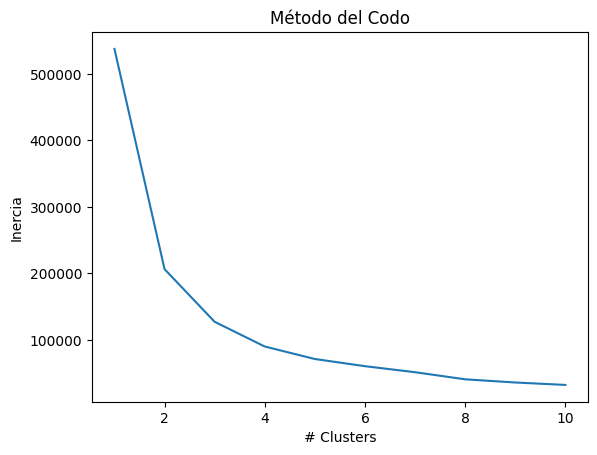

Número óptimo de clusters: 2


In [11]:
variable_X_C6H6 = df_median_imputed[['C6H6(GT)','DiaSemana']]

# Función que calcula y dibuja el gráfico para utilizar el método del codo.
def elbow_method_kmeans(data, range_a, range_b):
    inercia = []
    for i in range(range_a, range_b):
        kmeans = KMeans(n_clusters=i, random_state=0)
        kmeans.fit(data)
        inercia.append(kmeans.inertia_)
    
    # Gráfico del codo
    plt.plot(range(range_a, range_b), inercia)
    plt.xlabel('# Clusters')
    plt.ylabel('Inercia')
    plt.title('Método del Codo')
    plt.show()

    # Cálculo del cambio en la inercia
    diffs = np.diff(inercia)
    optimal_k = np.argmin(diffs) + range_a + 1  # +1 porque np.diff reduce la longitud de la lista
    return optimal_k

# Determinar el número óptimo de clusters
optimal_clusters = elbow_method_kmeans(variable_X_C6H6, 1, 11)
print(f'Número óptimo de clusters: {optimal_clusters}')


Evaluando KMeans...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Evaluando MeanShift...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Evaluando GMM...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Evaluando DBSCAN...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Evaluando AgglomerativeClustering...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Modelo: KMeans
Silhouette Score: 0.6381703326714864
Mejores hiperparámetros seleccionados:
  algorithm: lloyd
  copy_x: True
  init: k-means++
  max_iter: 300
  n_clusters: 2
  n_init: 10
  random_state: 42
  tol: 1e-05
  verbose: 0


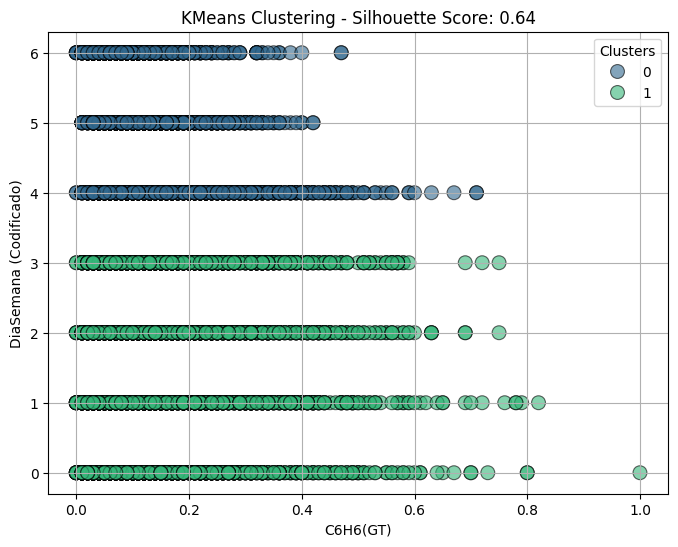


Modelo: MeanShift - No se puede calcular el Silhouette Score (n_clusters=1)

Modelo: GMM
Silhouette Score: 0.6378691342252749
Mejores hiperparámetros seleccionados:
  covariance_type: spherical
  init_params: random
  max_iter: 100
  means_init: None
  n_components: 3
  n_init: 10
  precisions_init: None
  random_state: 42
  reg_covar: 1e-06
  tol: 0.001
  verbose: 0
  verbose_interval: 10
  warm_start: False
  weights_init: None


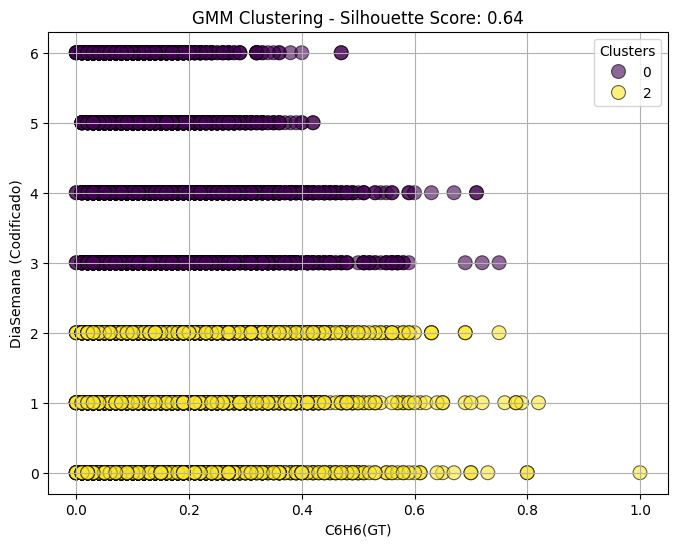


Modelo: DBSCAN - No se puede calcular el Silhouette Score (n_clusters=1)

Modelo: AgglomerativeClustering
Silhouette Score: 0.6378691342252749
Mejores hiperparámetros seleccionados:
  compute_distances: False
  compute_full_tree: True
  connectivity: None
  distance_threshold: None
  linkage: ward
  memory: None
  metric: euclidean
  n_clusters: 2


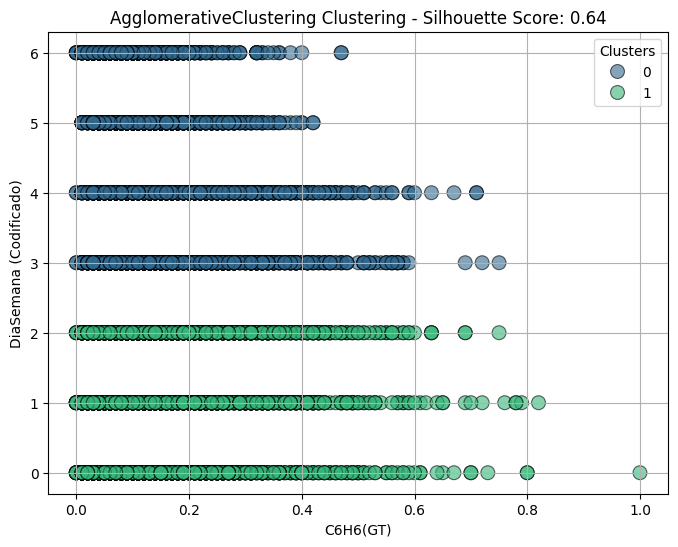

In [23]:
# Paso 2: Definir modelos y espacios de parámetros
clustering_models = {
    'KMeans': KMeans(),
    'MeanShift': MeanShift(),
    'GMM': GaussianMixture(),
    'DBSCAN': DBSCAN(),
    'AgglomerativeClustering': AgglomerativeClustering()
}

param_grids = {
    'KMeans': {
        'model__n_clusters': [optimal_clusters],                  # Número de clusters.
        'model__init': ['k-means++', 'random'],          # Método para inicializar los centros.
        'model__max_iter': [50, 200, 300, 500, 1000],                        # Máximo número de iteraciones.
        'model__tol': [1e-4, 1e-5, 1e-8],                            # Tolerancia para la convergencia.
        'model__algorithm': ['lloyd', 'elkan'],   # Algoritmo para el cálculo (auto es el predeterminado).
        'model__n_init': [10, 20, 30],                           # Número de inicializaciones del algoritmo.
        'model__random_state': [42]   
    },
    'MeanShift': {
        'model__bandwidth': [0.5, 1.0, 2.0, 3.0],              # Ancho de banda para el algoritmo.
        'model__bin_seeding': [True, False],             # Usar semillas de bin para acelerar el cálculo.
        'model__min_bin_freq': [1,  5],                      # Frecuencia mínima de puntos para considerar un bin.
        'model__cluster_all': [True, False],             # Si se agrupan todos los puntos o no.
        'model__max_iter': [300, 500 ]
    },
    'GMM': { 
        'model__n_components': [2, 3, 4, 5],                   # Número de componentes gaussianos (clusters).
        'model__covariance_type': ['full', 'tied', 'diag', 'spherical'],  # Tipo de matriz de covarianza.
        'model__tol': [1e-3, 1e-4, 1e-5],                      # Tolerancia para la convergencia.
        'model__reg_covar': [1e-6, 1e-5, 1e-4],                # Regularización para la covarianza.
        'model__max_iter': [100, 200, 300],                    # Máximo número de iteraciones.
        'model__n_init': [1, 5, 10],                           # Número de inicializaciones.
        'model__init_params': ['kmeans', 'random'],            # Método para inicialización.
        'model__random_state': [42]                            # Semilla para la aleatoriedad.
    },
    'DBSCAN': {
        'model__eps': [0.3, 0.5, 1.0],
        'model__min_samples': [5, 10, 20],
        'model__metric': ['euclidean', 'manhattan', 'minkowski'],
        'model__metric_params': [None],
        'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'model__leaf_size': [30],
        'model__p': [2],
        'model__n_jobs': [-1]
    },
    'AgglomerativeClustering': {
        'model__n_clusters':  [optimal_clusters],                      
        'model__metric': ['euclidean', 'manhattan'], 
        'model__memory': [None],                       
        'model__connectivity': [None],                  
        'model__linkage': ['ward', 'complete', 'average', 'single'],  
        'model__distance_threshold': [None],           
        'model__compute_full_tree': [True, False] 
    }

}

# Paso 3: Definir el scoring basado en Silhouette Score
silhouette_scorer = make_scorer(silhouette_score, metric='euclidean')

# Paso 4: Función para evaluar modelos de clustering
def evaluar_modelo_clustering(model, param_grid, X):
    pipeline = Pipeline(steps=[
        ('scaler', StandardScaler()),  # Estandarización previa
        ('model', model)
    ])
    
    grid_search = RandomizedSearchCV(   
        pipeline,
        param_distributions=param_grid,
        scoring=silhouette_scorer,
        n_iter=50,  # Limitar el número de combinaciones a probar
        verbose=2,
        n_jobs=-1,
        random_state=42
    )
    grid_search.fit(X)
    return grid_search.best_estimator_

# Paso 5: Preparar los datos
X = df_median_imputed_norm[['C6H6(GT)','DiaSemana']]  # Seleccionar columnas relevantes

# Paso 6: Evaluar modelos
mejores_modelos = {}
for model_name, model in clustering_models.items():
    print(f"\nEvaluando {model_name}...")
    mejores_modelos[model_name] = evaluar_modelo_clustering(
        model=model,
        param_grid=param_grids[model_name],
        X=X  # Pasamos el DataFrame directamente
    )

# Paso 7: Evaluar con Silhouette Score y mostrar hiperparámetros
for model_name, best_model in mejores_modelos.items():
    labels = best_model.named_steps['model'].fit_predict(X)
    
    # Excluir ruido (-1) de DBSCAN para contar clusters válidos
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    if n_clusters < 2:
        print(f"\nModelo: {model_name} - No se puede calcular el Silhouette Score (n_clusters={n_clusters})")
        continue  # Salta al siguiente modelo
    
    score = silhouette_score(X, labels)
    
    # Extraer los hiperparámetros seleccionados
    best_params = best_model.named_steps['model'].get_params()
    
    # Imprimir resultados
    print(f"\nModelo: {model_name}")
    print(f"Silhouette Score: {score}")
    print("Mejores hiperparámetros seleccionados:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")

    # Visualización del clustering
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X['C6H6(GT)'], y=X['DiaSemana'], hue=labels, palette="viridis", s=100, alpha=0.6, edgecolor='k')
    plt.title(f"{model_name} Clustering - Silhouette Score: {score:.2f}")
    plt.xlabel("C6H6(GT)")
    plt.ylabel("DiaSemana (Codificado)")
    plt.legend(title="Clusters", loc="upper right")
    plt.grid(True)
    plt.show()


# NOx x dias de la semana

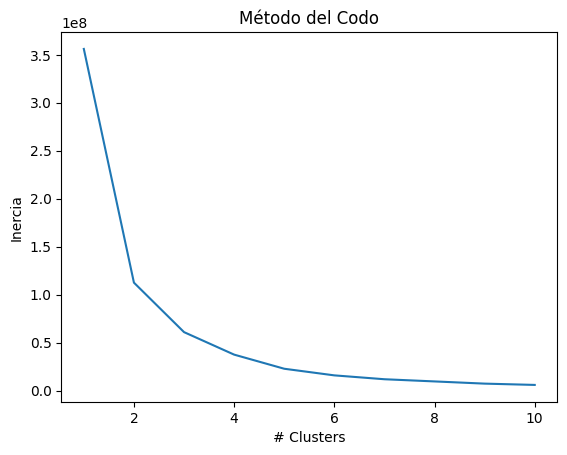

Número óptimo de clusters: 2


In [14]:
variable_X_NOx = df_median_imputed[['NOx(GT)','DiaSemana']]

# Función que calcula y dibuja el gráfico para utilizar el método del codo.
def elbow_method_kmeans(data, range_a, range_b):
    inercia = []
    for i in range(range_a, range_b):
        kmeans = KMeans(n_clusters=i, random_state=0)
        kmeans.fit(data)
        inercia.append(kmeans.inertia_)
    
    # Gráfico del codo
    plt.plot(range(range_a, range_b), inercia)
    plt.xlabel('# Clusters')
    plt.ylabel('Inercia')
    plt.title('Método del Codo')
    plt.show()

    # Cálculo del cambio en la inercia
    diffs = np.diff(inercia)
    optimal_k = np.argmin(diffs) + range_a + 1  # +1 porque np.diff reduce la longitud de la lista
    return optimal_k

# Determinar el número óptimo de clusters
optimal_clusters = elbow_method_kmeans(variable_X_NOx, 1, 11)
print(f'Número óptimo de clusters: {optimal_clusters}')


Evaluando KMeans...
Fitting 1 folds for each of 180 candidates, totalling 180 fits

Evaluando MeanShift...
Fitting 1 folds for each of 64 candidates, totalling 64 fits

Evaluando GMM...
Fitting 1 folds for each of 2592 candidates, totalling 2592 fits

Evaluando DBSCAN...
Fitting 1 folds for each of 108 candidates, totalling 108 fits

Evaluando AgglomerativeClustering...
Fitting 1 folds for each of 16 candidates, totalling 16 fits

Modelo: KMeans
Silhouette Score: 0.6366318143286648
Mejores hiperparámetros seleccionados:
  algorithm: lloyd
  copy_x: True
  init: k-means++
  max_iter: 50
  n_clusters: 2
  n_init: 10
  random_state: 42
  tol: 0.0001
  verbose: 0


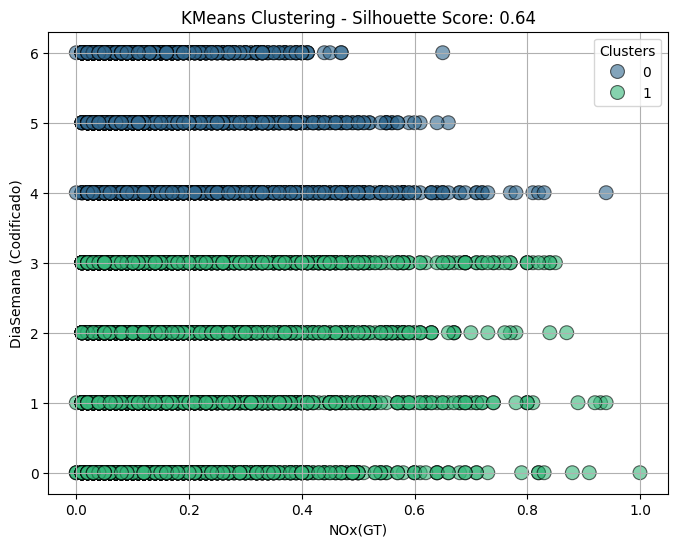


Modelo: MeanShift
Silhouette Score: 0.8764044398653803
Mejores hiperparámetros seleccionados:
  bandwidth: 0.5
  bin_seeding: True
  cluster_all: True
  max_iter: 300
  min_bin_freq: 1
  n_jobs: None
  seeds: None


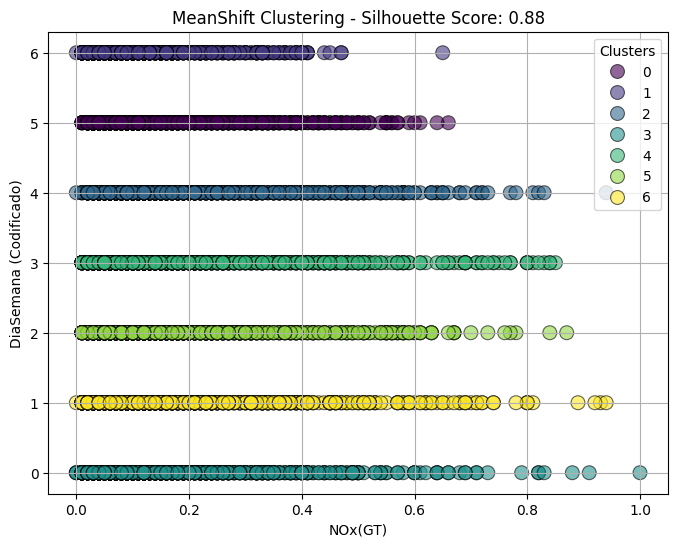


Modelo: GMM
Silhouette Score: -0.00993884403834238
Mejores hiperparámetros seleccionados:
  covariance_type: full
  init_params: kmeans
  max_iter: 100
  means_init: None
  n_components: 2
  n_init: 1
  precisions_init: None
  random_state: 42
  reg_covar: 1e-06
  tol: 0.001
  verbose: 0
  verbose_interval: 10
  warm_start: False
  weights_init: None


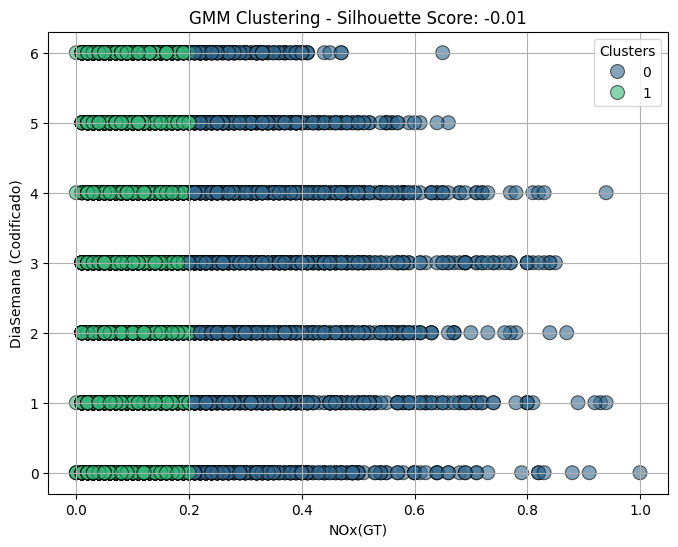


Modelo: DBSCAN
Silhouette Score: 0.8764044398653803
Mejores hiperparámetros seleccionados:
  algorithm: auto
  eps: 0.3
  leaf_size: 30
  metric: euclidean
  metric_params: None
  min_samples: 5
  n_jobs: -1
  p: 2


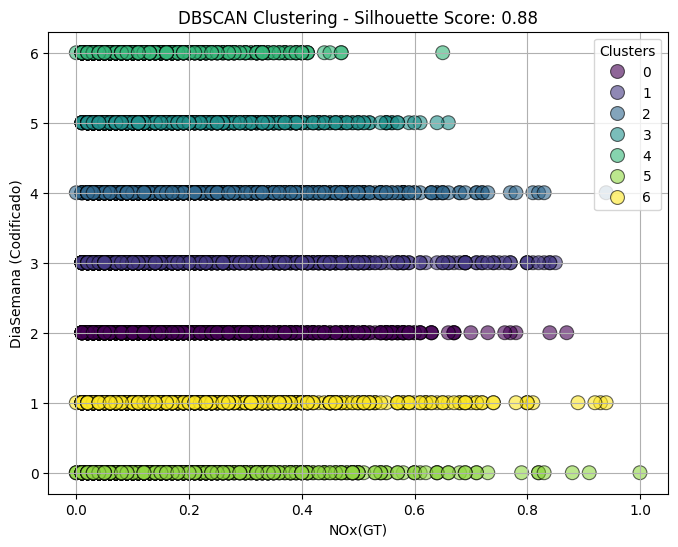


Modelo: AgglomerativeClustering
Silhouette Score: 0.6366548370757303
Mejores hiperparámetros seleccionados:
  compute_distances: False
  compute_full_tree: True
  connectivity: None
  distance_threshold: None
  linkage: ward
  memory: None
  metric: euclidean
  n_clusters: 2


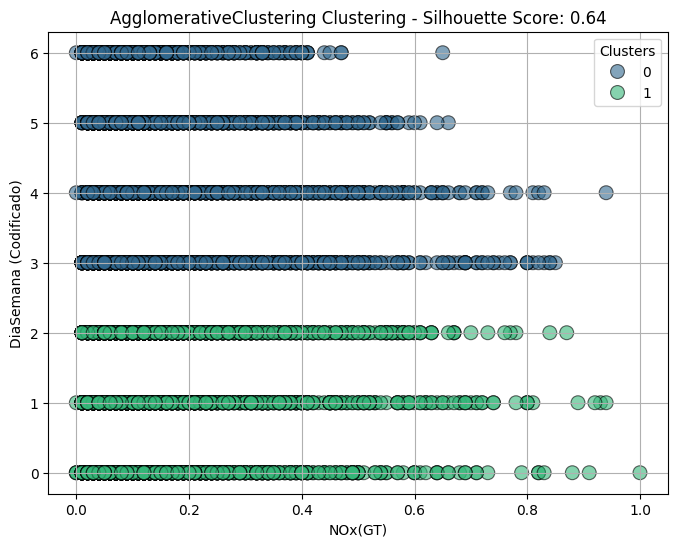

In [15]:
# Paso 2: Definir modelos y espacios de parámetros
clustering_models = {
    'KMeans': KMeans(),
    'MeanShift': MeanShift(),
    'GMM': GaussianMixture(),
    'DBSCAN': DBSCAN(),
    'AgglomerativeClustering': AgglomerativeClustering()
}

param_grids = {
    'KMeans': {
        'model__n_clusters': [optimal_clusters],                  # Número de clusters.
        'model__init': ['k-means++', 'random'],          # Método para inicializar los centros.
        'model__max_iter': [50, 200, 300, 500, 1000],                        # Máximo número de iteraciones.
        'model__tol': [1e-4, 1e-5, 1e-8],                            # Tolerancia para la convergencia.
        'model__algorithm': ['lloyd', 'elkan'],   # Algoritmo para el cálculo (auto es el predeterminado).
        'model__n_init': [10, 20, 30],                           # Número de inicializaciones del algoritmo.
        'model__random_state': [42]   
    },
    'MeanShift': {
        'model__bandwidth': [0.5, 1.0, 2.0, 3.0],              # Ancho de banda para el algoritmo.
        'model__bin_seeding': [True, False],             # Usar semillas de bin para acelerar el cálculo.
        'model__min_bin_freq': [1,  5],                      # Frecuencia mínima de puntos para considerar un bin.
        'model__cluster_all': [True, False],             # Si se agrupan todos los puntos o no.
        'model__max_iter': [300, 500 ]
    },
    'GMM': { 
        'model__n_components': [2, 3, 4, 5],                   # Número de componentes gaussianos (clusters).
        'model__covariance_type': ['full', 'tied', 'diag', 'spherical'],  # Tipo de matriz de covarianza.
        'model__tol': [1e-3, 1e-4, 1e-5],                      # Tolerancia para la convergencia.
        'model__reg_covar': [1e-6, 1e-5, 1e-4],                # Regularización para la covarianza.
        'model__max_iter': [100, 200, 300],                    # Máximo número de iteraciones.
        'model__n_init': [1, 5, 10],                           # Número de inicializaciones.
        'model__init_params': ['kmeans', 'random'],            # Método para inicialización.
        'model__random_state': [42]                            # Semilla para la aleatoriedad.
    },
    'DBSCAN': {
        'model__eps': [0.3, 0.5, 1.0],
        'model__min_samples': [5, 10, 20],
        'model__metric': ['euclidean', 'manhattan', 'minkowski'],
        'model__metric_params': [None],
        'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'model__leaf_size': [30],
        'model__p': [2],
        'model__n_jobs': [-1]
    },
    'AgglomerativeClustering': {
        'model__n_clusters':  [optimal_clusters],                      
        'model__metric': ['euclidean', 'manhattan'], 
        'model__memory': [None],                       
        'model__connectivity': [None],                  
        'model__linkage': ['ward', 'complete', 'average', 'single'],  
        'model__distance_threshold': [None],           
        'model__compute_full_tree': [True, False] 
    }

}

# Paso 3: Definir el scoring basado en Silhouette Score
silhouette_scorer = make_scorer(silhouette_score, metric='euclidean')

# Paso 4: Función para evaluar modelos de clustering
def evaluar_modelo_clustering(model, param_grid, X):
    pipeline = Pipeline(steps=[ 
        ('model', model)            
    ])
    
    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring=silhouette_scorer,  # Usamos Silhouette Score como métrica
        cv=[(slice(None), slice(None))],  # Sin partición (compatible con clustering)
        verbose=2,
        n_jobs=-1
    )
    grid_search.fit(X)
    return grid_search.best_estimator_

# Paso 5: Preparar los datos
X = df_median_imputed_norm[['NOx(GT)','DiaSemana']]  # Seleccionar columnas relevantes

# Paso 6: Evaluar modelos
mejores_modelos = {}
for model_name, model in clustering_models.items():
    print(f"\nEvaluando {model_name}...")
    mejores_modelos[model_name] = evaluar_modelo_clustering(
        model=model,
        param_grid=param_grids[model_name],
        X=X  # Pasamos el DataFrame directamente
    )

# Paso 7: Evaluar con Silhouette Score y mostrar hiperparámetros
for model_name, best_model in mejores_modelos.items():
    labels = best_model.named_steps['model'].fit_predict(X)
    score = silhouette_score(X, labels)
    
    # Extraer los hiperparámetros seleccionados
    best_params = best_model.named_steps['model'].get_params()
    
    # Imprimir resultados
    print(f"\nModelo: {model_name}")
    print(f"Silhouette Score: {score}")
    print("Mejores hiperparámetros seleccionados:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")

    # Visualización del clustering
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X['NOx(GT)'], y=X['DiaSemana'], hue=labels, palette="viridis", s=100, alpha=0.6, edgecolor='k')
    plt.title(f"{model_name} Clustering - Silhouette Score: {score:.2f}")
    plt.xlabel("NOx(GT)")
    plt.ylabel("DiaSemana (Codificado)")
    plt.legend(title="Clusters", loc="upper right")
    plt.grid(True)
    plt.show()

# NO2 x dias de la semana

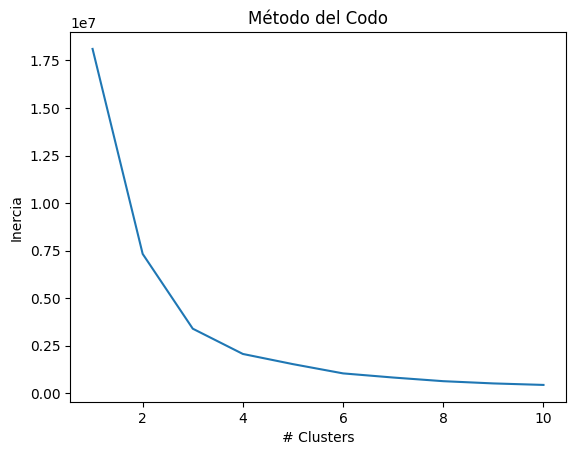

Número óptimo de clusters: 2


In [16]:
variable_X_NO2 = df_median_imputed[['NO2(GT)','DiaSemana']]

# Función que calcula y dibuja el gráfico para utilizar el método del codo.
def elbow_method_kmeans(data, range_a, range_b):
    inercia = []
    for i in range(range_a, range_b):
        kmeans = KMeans(n_clusters=i, random_state=0)
        kmeans.fit(data)
        inercia.append(kmeans.inertia_)
    
    # Gráfico del codo
    plt.plot(range(range_a, range_b), inercia)
    plt.xlabel('# Clusters')
    plt.ylabel('Inercia')
    plt.title('Método del Codo')
    plt.show()

    # Cálculo del cambio en la inercia
    diffs = np.diff(inercia)
    optimal_k = np.argmin(diffs) + range_a + 1  # +1 porque np.diff reduce la longitud de la lista
    return optimal_k

# Determinar el número óptimo de clusters
optimal_clusters = elbow_method_kmeans(variable_X_NO2, 1, 11)
print(f'Número óptimo de clusters: {optimal_clusters}')


Evaluando KMeans...
Fitting 1 folds for each of 180 candidates, totalling 180 fits

Evaluando MeanShift...
Fitting 1 folds for each of 64 candidates, totalling 64 fits

Evaluando GMM...
Fitting 1 folds for each of 2592 candidates, totalling 2592 fits

Evaluando DBSCAN...
Fitting 1 folds for each of 108 candidates, totalling 108 fits

Evaluando AgglomerativeClustering...
Fitting 1 folds for each of 16 candidates, totalling 16 fits

Modelo: KMeans
Silhouette Score: 0.6357921237241421
Mejores hiperparámetros seleccionados:
  algorithm: lloyd
  copy_x: True
  init: k-means++
  max_iter: 50
  n_clusters: 2
  n_init: 10
  random_state: 42
  tol: 0.0001
  verbose: 0


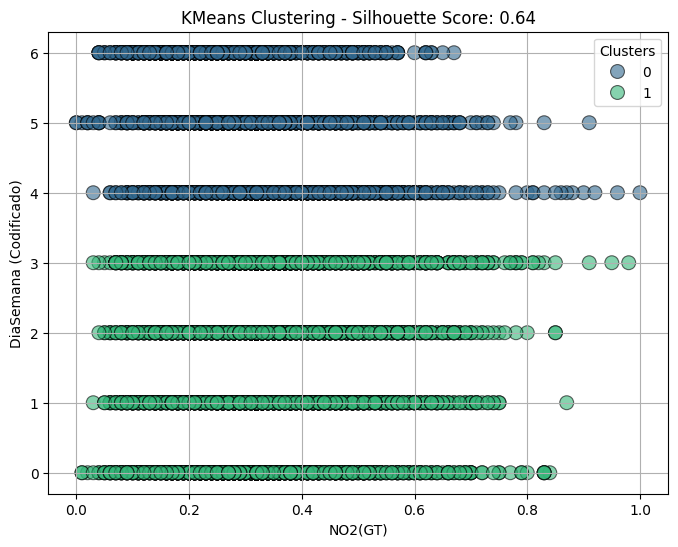


Modelo: MeanShift
Silhouette Score: 0.8643166049722588
Mejores hiperparámetros seleccionados:
  bandwidth: 0.5
  bin_seeding: True
  cluster_all: True
  max_iter: 300
  min_bin_freq: 1
  n_jobs: None
  seeds: None


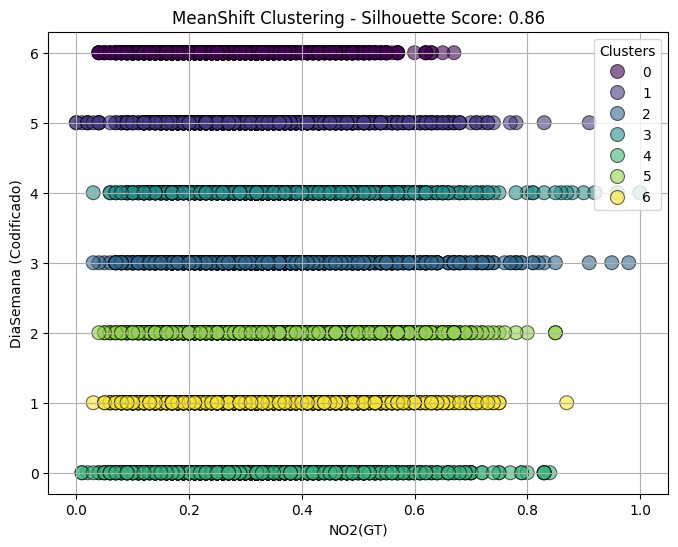


Modelo: GMM
Silhouette Score: 0.6358708343253638
Mejores hiperparámetros seleccionados:
  covariance_type: full
  init_params: kmeans
  max_iter: 100
  means_init: None
  n_components: 2
  n_init: 1
  precisions_init: None
  random_state: 42
  reg_covar: 1e-06
  tol: 0.001
  verbose: 0
  verbose_interval: 10
  warm_start: False
  weights_init: None


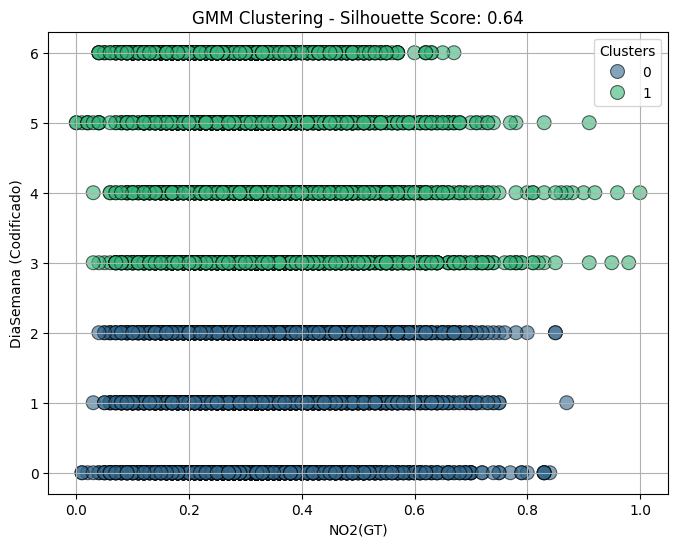


Modelo: DBSCAN
Silhouette Score: 0.8643166049722588
Mejores hiperparámetros seleccionados:
  algorithm: auto
  eps: 0.3
  leaf_size: 30
  metric: euclidean
  metric_params: None
  min_samples: 5
  n_jobs: -1
  p: 2


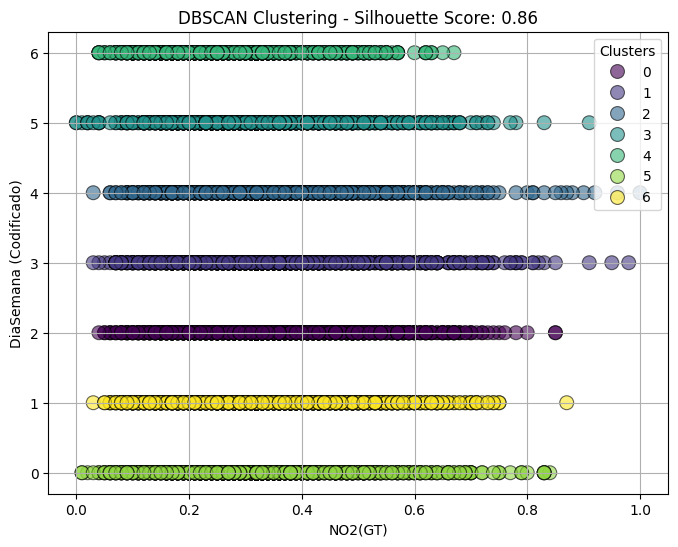


Modelo: AgglomerativeClustering
Silhouette Score: 0.6358708343253638
Mejores hiperparámetros seleccionados:
  compute_distances: False
  compute_full_tree: True
  connectivity: None
  distance_threshold: None
  linkage: ward
  memory: None
  metric: euclidean
  n_clusters: 2


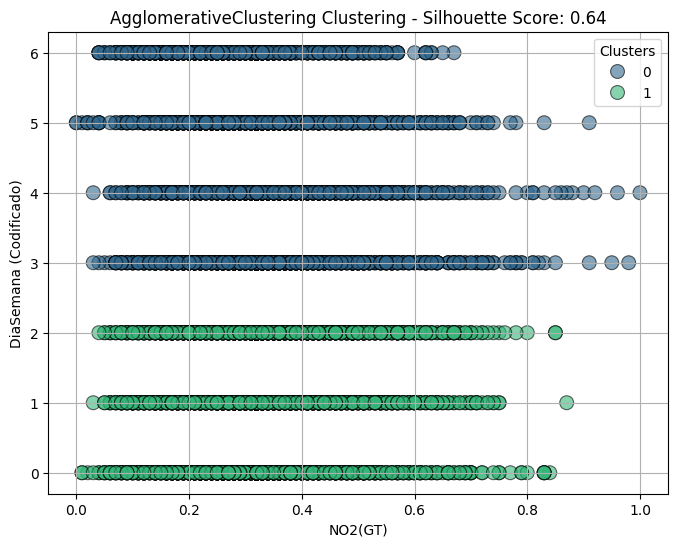

In [17]:
# Paso 2: Definir modelos y espacios de parámetros
clustering_models = {
    'KMeans': KMeans(),
    'MeanShift': MeanShift(),
    'GMM': GaussianMixture(),
    'DBSCAN': DBSCAN(),
    'AgglomerativeClustering': AgglomerativeClustering()
}

param_grids = {
    'KMeans': {
        'model__n_clusters': [optimal_clusters],                  # Número de clusters.
        'model__init': ['k-means++', 'random'],          # Método para inicializar los centros.
        'model__max_iter': [50, 200, 300, 500, 1000],                        # Máximo número de iteraciones.
        'model__tol': [1e-4, 1e-5, 1e-8],                            # Tolerancia para la convergencia.
        'model__algorithm': ['lloyd', 'elkan'],   # Algoritmo para el cálculo (auto es el predeterminado).
        'model__n_init': [10, 20, 30],                           # Número de inicializaciones del algoritmo.
        'model__random_state': [42]   
    },
    'MeanShift': {
        'model__bandwidth': [0.5, 1.0, 2.0, 3.0],              # Ancho de banda para el algoritmo.
        'model__bin_seeding': [True, False],             # Usar semillas de bin para acelerar el cálculo.
        'model__min_bin_freq': [1,  5],                      # Frecuencia mínima de puntos para considerar un bin.
        'model__cluster_all': [True, False],             # Si se agrupan todos los puntos o no.
        'model__max_iter': [300, 500 ]
    },
    'GMM': { 
        'model__n_components': [2, 3, 4, 5],                   # Número de componentes gaussianos (clusters).
        'model__covariance_type': ['full', 'tied', 'diag', 'spherical'],  # Tipo de matriz de covarianza.
        'model__tol': [1e-3, 1e-4, 1e-5],                      # Tolerancia para la convergencia.
        'model__reg_covar': [1e-6, 1e-5, 1e-4],                # Regularización para la covarianza.
        'model__max_iter': [100, 200, 300],                    # Máximo número de iteraciones.
        'model__n_init': [1, 5, 10],                           # Número de inicializaciones.
        'model__init_params': ['kmeans', 'random'],            # Método para inicialización.
        'model__random_state': [42]                            # Semilla para la aleatoriedad.
    },
    'DBSCAN': {
        'model__eps': [0.3, 0.5, 1.0],
        'model__min_samples': [5, 10, 20],
        'model__metric': ['euclidean', 'manhattan', 'minkowski'],
        'model__metric_params': [None],
        'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'model__leaf_size': [30],
        'model__p': [2],
        'model__n_jobs': [-1]
    },
    'AgglomerativeClustering': {
        'model__n_clusters':  [optimal_clusters],                      
        'model__metric': ['euclidean', 'manhattan'], 
        'model__memory': [None],                       
        'model__connectivity': [None],                  
        'model__linkage': ['ward', 'complete', 'average', 'single'],  
        'model__distance_threshold': [None],           
        'model__compute_full_tree': [True, False] 
    }

}

# Paso 3: Definir el scoring basado en Silhouette Score
silhouette_scorer = make_scorer(silhouette_score, metric='euclidean')

# Paso 4: Función para evaluar modelos de clustering
def evaluar_modelo_clustering(model, param_grid, X):
    pipeline = Pipeline(steps=[ 
        ('model', model)            
    ])
    
    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring=silhouette_scorer,  # Usamos Silhouette Score como métrica
        cv=[(slice(None), slice(None))],  # Sin partición (compatible con clustering)
        verbose=2,
        n_jobs=-1
    )
    grid_search.fit(X)
    return grid_search.best_estimator_

# Paso 5: Preparar los datos
X = df_median_imputed_norm[['NO2(GT)','DiaSemana']]  # Seleccionar columnas relevantes

# Paso 6: Evaluar modelos
mejores_modelos = {}
for model_name, model in clustering_models.items():
    print(f"\nEvaluando {model_name}...")
    mejores_modelos[model_name] = evaluar_modelo_clustering(
        model=model,
        param_grid=param_grids[model_name],
        X=X  # Pasamos el DataFrame directamente
    )

# Paso 7: Evaluar con Silhouette Score y mostrar hiperparámetros
for model_name, best_model in mejores_modelos.items():
    labels = best_model.named_steps['model'].fit_predict(X)
    score = silhouette_score(X, labels)
    
    # Extraer los hiperparámetros seleccionados
    best_params = best_model.named_steps['model'].get_params()
    
    # Imprimir resultados
    print(f"\nModelo: {model_name}")
    print(f"Silhouette Score: {score}")
    print("Mejores hiperparámetros seleccionados:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")

    # Visualización del clustering
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X['NO2(GT)'], y=X['DiaSemana'], hue=labels, palette="viridis", s=100, alpha=0.6, edgecolor='k')
    plt.title(f"{model_name} Clustering - Silhouette Score: {score:.2f}")
    plt.xlabel("NO2(GT)")
    plt.ylabel("DiaSemana (Codificado)")
    plt.legend(title="Clusters", loc="upper right")
    plt.grid(True)
    plt.show()